In [1]:
"""
Notebook utilizado para apresentar uma introdução à teoria da amostragem de sinais.
Criado para a disciplina Geofísica I da Universidade Federal de Uberlândia.

Protegido por licença GPL v3.0. O uso e a reprodução são livres para fins educacionais
desde que citada a fonte.

Prof. Dr. Emerson Rodrigo Almeida
emerson.almeida@ufu.br

Última modificação: 02/02/2021
"""

'\nNotebook utilizado para apresentar uma introdução à teoria da amostragem de sinais.\nCriado para a disciplina Geofísica I da Universidade Federal de Uberlândia.\n\nProtegido por licença GPL v3.0. O uso e a reprodução são livres para fins educacionais\ndesde que citada a fonte.\n\nProf. Dr. Emerson Rodrigo Almeida\nemerson.almeida@ufu.br\n\nÚltima modificação: 02/02/2021\n'

# Instruções iniciais

Neste notebook você irá aprender como funciona a filtragem de frequências indesejadas em sinais. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

### Passo 01 - Preparação

Primeiramente vamos preparar o notebook com os módulos e funções que precisaremos no decorrer da demonstração. A célula abaixo contém as funções utilizadas nos cálculos e as funções utilizadas para gerar as figuras. Execute-a uma vez antes de executar qualquer outra parte do código e **não altere nada no código apresentado na célula**. Você pode executar o código na célula clicando no botão RUN na barra do Jupyter Notebook ou pressionando as teclas SHIFT+ENTER no seu teclado.

In [82]:
from scipy.fftpack import fft, fftfreq, ifft
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


# o que estiver ok vem pra cá

def gera_sinal(a, f, t_max):
    """
    Gera uma função obtida a partir de uma sobreposição de funções seno, onde cada uma delas é caracterizada por
    uma amplitude A e frequência f na forma s(t) = A * cos(2 * pi * f * t). A sobreposição destas funções será o sinal
    analógico de referência. Esta função pode ser amostrada em qualquer instante de tempo que se queira, de forma 
    que esta é a melhor forma de representar um sinal contínuo para os objetivos desta demonstração.
    """
    
    dt = t_max/1000
    tt = np.arange(0, t_max + dt, dt)                        # eixo de tempo estendido
    
    s = np.zeros(np.shape(tt))
    
    for i in range(len(a)):
        s = s + (a[i] * np.sin(2 * np.pi * f[i] * tt))
        
    ruido = np.random.normal(loc=0.0, scale=1, size=tt.shape)   # ruído branco para estabilizar a filtragem
    
    return s, tt      # função que caracteriza o sinal analógico



def calcula_espectro(tt, ss):
    
    dt = tt[1] - tt[0]
    n_amostras = len(ss)

    espectro = fft(ss, axis=0)
    ff = fftfreq(len(ss), dt)
    
    return ff, espectro


def gera_filtro(f_c, forma):
    df = frequencias[1] - frequencias[0]
    i_max_freq = np.abs(frequencias-np.max(frequencias)).argmin()   # indice da máxima frequência positiva
    delta_rampa = 3*df

    if forma=='passa-baixa':
        amp_caixa = [1, 1, 0, 0]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa = f_c[0] + delta_rampa        # frequência no fim da rampa do filtro
        f_caixa_pos = np.array([frequencias[0], f_c[0], f_rampa, np.max(frequencias)]) # caixa para a parte positiva do espectro

    elif forma=='passa-alta':
        amp_caixa = [0, 0, 1, 1]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa = f_c[0] - delta_rampa        # frequência no início da rampa do filtro
        f_caixa_pos = np.array([frequencias[0], f_rampa, f_c[0], np.max(frequencias)]) # caixa para a parte positiva do espectro

    elif forma=='passa-banda':
        amp_caixa = [0, 0, 1, 1, 0, 0]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa_sub = f_c[0] - delta_rampa        # frequência no início da rampa do filtro
        f_rampa_desc = f_c[1] + delta_rampa        # frequência no fim da rampa do filtro
        f_caixa_pos = np.array([frequencias[0], f_rampa_sub, f_c[0], f_c[1], f_rampa_desc, np.max(frequencias)]) # caixa para a parte positiva do espectro

    elif forma=='rejeita-banda':
        amp_caixa = [1, 1, 0, 0, 1, 1]    # amplitudes da caixa do filtro na parte positiva do espectro
        f_rampa_desc = f_c[0] - delta_rampa        # frequência no fim da rampa do filtro
        f_rampa_sub = f_c[1] + delta_rampa        # frequência no inicio da rampa do filtro
        f_caixa_pos = np.array([frequencias[0], f_rampa_desc, f_c[0], f_c[1], f_rampa_sub, np.max(frequencias)]) # caixa para a parte positiva do espectro

    # espelhamnto da caixa na parte positiva do espectro
    f_caixa_neg = np.flip(-1 * f_caixa_pos)   # caixa para a parte negativa do espectro
    f_caixa_neg[-1] = frequencias[-1]
    f_caixa_neg[0] = frequencias[i_max_freq+1]

    # interpolação das funções caixa para as frequências do espectro
    caixa_pos = interp1d(f_caixa_pos, amp_caixa, kind='linear')
    caixa_neg = interp1d(f_caixa_neg, np.flip(amp_caixa), kind='linear')

    return np.concatenate([caixa_pos(frequencias[:i_max_freq+1]), caixa_neg(frequencias[i_max_freq+1:])], axis=0)


def executa_filtragem(espec, f_c, forma):
    filtro = gera_filtro(f_c, forma)
    amp_filtrada = espec * filtro
    
    return np.real(ifft(amp_filtrada))


# funções das figuras
def plota_sinal(tt, ss, titulo):
    """
    Plota o sinal calculado pela sobreposição das funções seno.
    """
    
    fig, ax = plt.subplots(figsize=(15,3))
    ax.plot(tt, ss)
    ax.set_xlabel("Tempo (s)", fontsize=14)
    ax.set_ylabel("Amplitude (ua)", fontsize=14)
    ax.set_title(titulo, fontsize=14)
    ax.set_xlim([tt[0], tt[-1]])
    ax.grid()

    
def plota_espectro(ff, espec, titulo):
    n_samples = len(espec)       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais

    nf_positivas = round(n_samples / 2) + 1     # número de frequências positivas
    amplitudes = (2 / n_samples) * np.abs(espec[:nf_positivas])
    frequencias = ff[:nf_positivas]
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stem(frequencias, amplitudes)
    ax.set_xlabel('Frequência (Hz)', fontsize=14)
    ax.set_ylabel('Amplitude (ua)', fontsize=14)
    ax.set_xlim([0, np.max(frequencias)])
    ax.set_ylim([0, np.max(amplitudes)*1.25])
    ax.set_title(titulo, fontsize=14)
    # ax.set_xticks(np.arange(0, frequencias[-1], 2))
    ax.grid()
    
    
def plota_filtragem(espec, ff, f_c, forma):
    """
    Apenas plota a representação da seleção de frequências com o filtro sobre a parte
    positiva do espectro, porém não executa a filtragem propriamente dita    
    """
        
    n_samples = len(espec)       # vai ser o mesmo número de amostras do sinal porque a fft não usou zeros adicionais
    nf_positivas = round(n_samples / 2) + 1     # número de frequências positivas
    amplitudes = (2 / n_samples) * np.abs(espec[:nf_positivas])
    ff = frequencias[:nf_positivas]

    filtro = gera_filtro(f_c, forma)
    escala_filtro = np.max(amplitudes) + 0.10 * np.max(amplitudes)   # escala gráfica para plotar o contorno do filtro

    fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(13,7))
    ax[0].stem(ff, amplitudes)
    ax[0].plot(ff, filtro[:nf_positivas] * escala_filtro, '--r')
    ax[0].set_xlabel('Frequência (Hz)', fontsize=14)
    ax[0].set_ylabel('Amplitude (ua)', fontsize=14)
    ax[0].set_xlim([0, np.max(ff)])
    ax[0].set_ylim([0, np.max(amplitudes)*1.25])
    ax[0].set_title("Figura 3a. Filtro " + tipo + " sobre o espectro", fontsize=14)
    #ax[0].set_xticks(np.arange(0, ff[-1], 2))
    ax[0].grid()

    ax[1].stem(ff, amplitudes * filtro[:nf_positivas])
    ax[1].set_xlabel('Frequência (Hz)', fontsize=14)
    ax[1].set_ylabel('Amplitude (ua)', fontsize=14)
    ax[1].set_xlim([0, np.max(ff)])
    ax[1].set_ylim([0, np.max(amplitudes)*1.25])
    ax[1].set_title("Figura 3b. Frequências remanescentes após a filtragem", fontsize=14)
    #ax[1].set_xticks(np.arange(0, ff[-1], 2))
    ax[1].grid()

    plt.tight_layout()
    
    
def plota_gabarito(tt, s_filtrado, s_limpo, titulo):

    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(tt, s_limpo, '-b', alpha=0.3, linewidth=3, label='Sinal limpo (gabarito)')
    ax.plot(tt, s_filtrado, '-r', label='Sinal após a sua filtragem')
    ax.legend(loc='lower right', fontsize=12)
    ax.set_xlim([0, np.max(tt)])
    ax.set_ylim([np.min([s_filtrado, s_limpo])*1.25, np.max([s_filtrado, s_limpo])*1.25])
    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel("Tempo (s)", fontsize=14)
    ax.set_ylabel("Amplitude (ua)", fontsize=14)
    ax.grid()
    




    

In [3]:
a1 = 1.00      # amplitude da componente s_1(t) em unidades de amplitude
f1 = 1.00      # frequência da componente s_1(t) em Hertz

a2 = 0.50      # amplitude da componente s_2(t) em unidades de amplitude
f2 = 3.00      # frequência da componente s_2(t) em Hertz

a3 = 1.50      # amplitude da componente s_3(t) em unidades de amplitude
f3 = 15.0      # frequência da componente s_3(t) em Hertz

a4 = 2.75      # amplitude da componente s_4(t) em unidades de amplitude
f4 = 0.50      # frequência da componente s_4(t) em Hertz

a5 = 0.80      # amplitude da componente s_5(t) em unidades de amplitude
f5 = 7.00      # frequência da componente s_5(t) em Hertz

janela_tempo = 20.0              # janela temporal em segundos

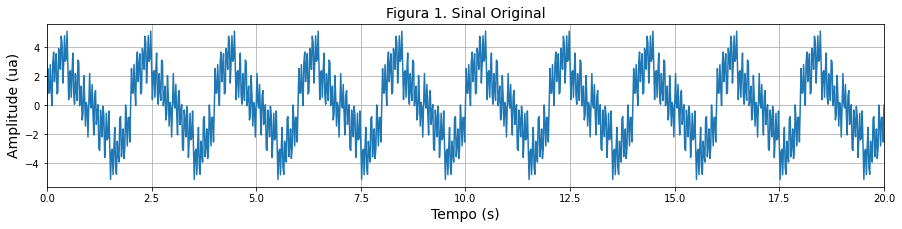

In [4]:
sinal, tempo = gera_sinal([a1, a2, a3, a4, a5], [f1, f2, f3, f4, f5], janela_tempo)
plota_sinal(tempo, sinal, "Figura 1. Sinal Original")

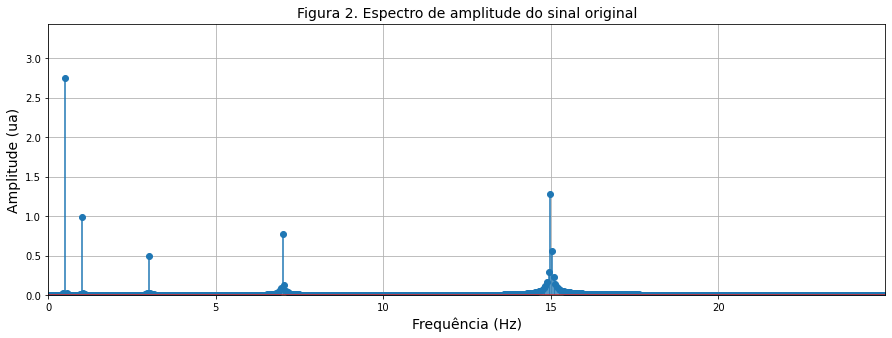

In [5]:
frequencias, amplitude_f = calcula_espectro(tempo, sinal)  # retorna o espectro completo (frequencias positivas e negativas)
plota_espectro(frequencias, amplitude_f, "Figura 2. Espectro de amplitude do sinal original")

In [6]:
f_corte = [5.0]         # ATENÇÃO: coloque sempre entre colchetes aqui, mesmo que seja um único número
tipo = 'passa-baixa'

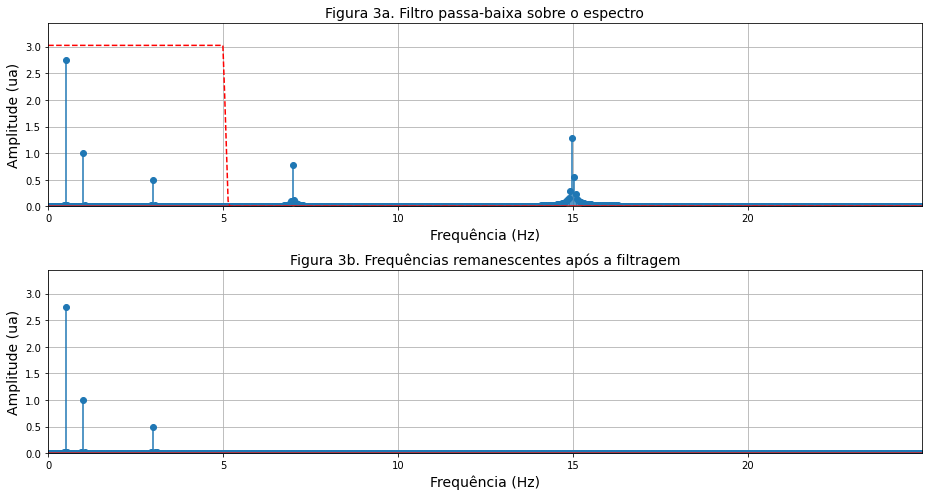

In [7]:
plota_filtragem(amplitude_f, frequencias, f_corte, tipo)

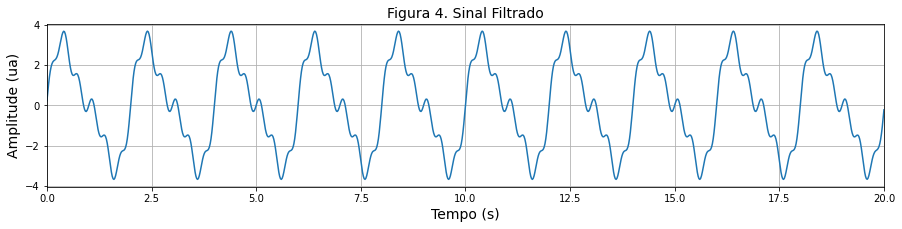

In [8]:
sinal_filtrado = executa_filtragem(amplitude_f, f_corte, tipo)
plota_sinal(tempo, sinal_filtrado, "Figura 4. Sinal Filtrado")

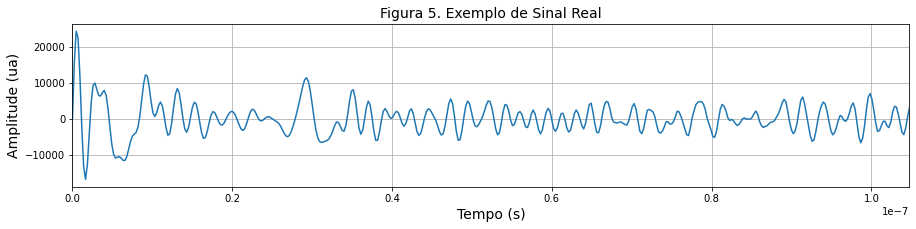

In [64]:
dado_real = np.loadtxt('radar.txt')

tempo = dado_real[:, 0]
sinal_real = dado_real[:, 1]
sinal_contaminado = dado_real[:, 2]

plota_sinal(tempo, sinal_contaminado, "Figura 5. Exemplo de Sinal Real")

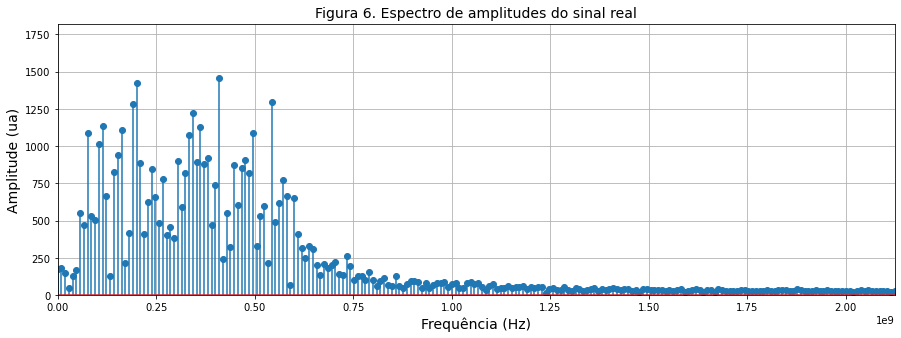

In [58]:
frequencias, amplitude_f = calcula_espectro(tempo, sinal)
plota_espectro(frequencias, amplitude_f, "Figura 6. Espectro de amplitudes do sinal real")

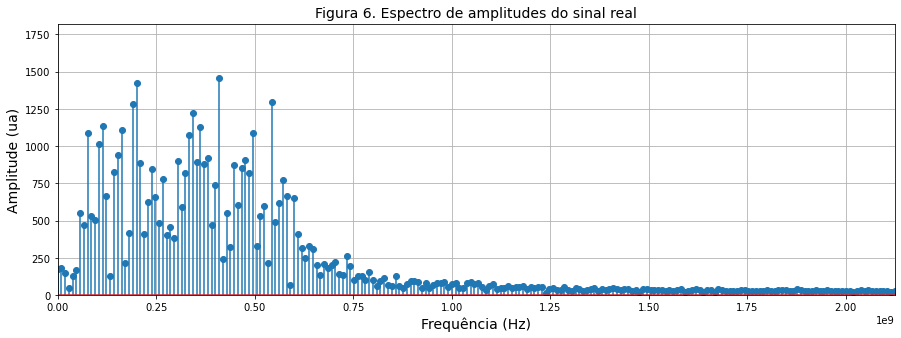

In [59]:
frequencias, amplitude_f = calcula_espectro(tempo, sinal)
plota_espectro(frequencias, amplitude_f, "Figura 6. Espectro de amplitudes do sinal real")

In [90]:
f_corte = [0.01e9, 1e9]         # ATENÇÃO: coloque sempre entre colchetes aqui, mesmo que seja um único número
tipo = 'passa-banda'

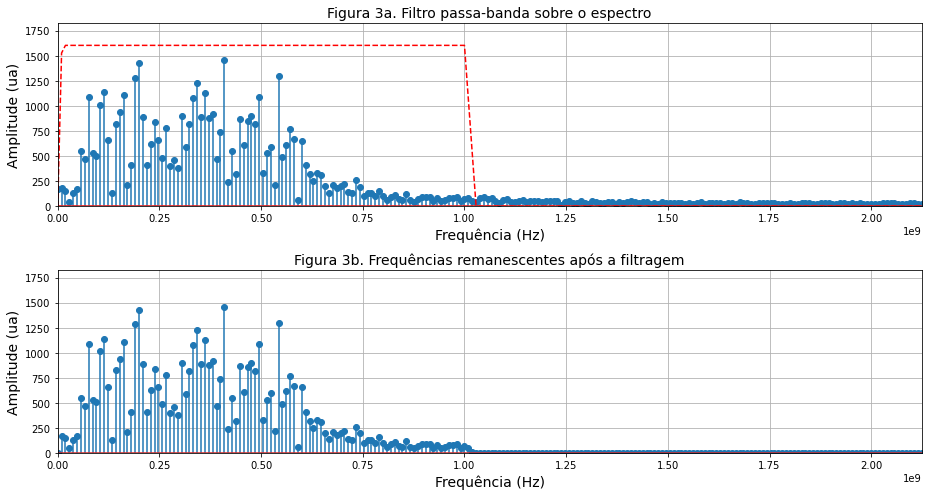

In [91]:
plota_filtragem(amplitude_f, frequencias, f_corte, tipo)

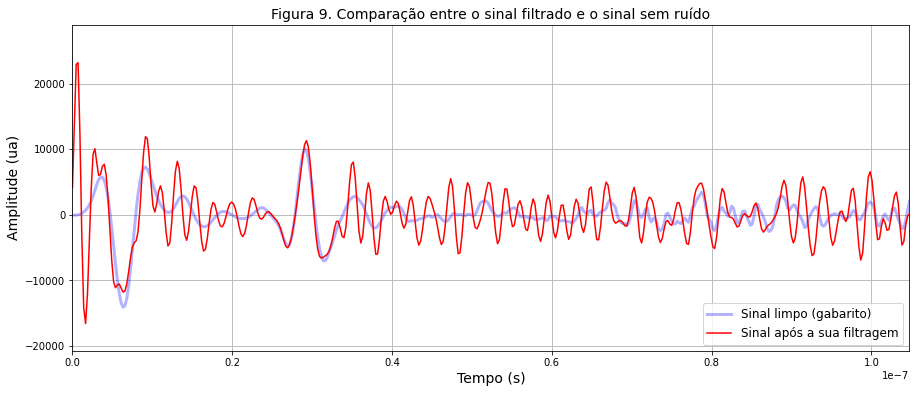

In [92]:
sinal_filtrado = executa_filtragem(amplitude_f, f_corte, tipo)
plota_gabarito(tempo, sinal_filtrado, sinal_real, "Figura 9. Comparação entre o sinal filtrado e o sinal sem ruído")

In [ ]:
[0.05e9, 0.3e9]